#Project Overview
Computer vision can be used to automate supervision and trigger appropriate actions if an event is predicted from an image of interest.
For example, food items can be easily identified by a camera based on:

- The type of food

- Color

- Ingredients, etc.

## 📊 Data Description
The Food101 dataset contains 16,256 images across 17 food classes.

Each class can be roughly split into 70% training and 30% testing.

Classes are typically food names (e.g., apple_pie, chicken_curry).

The dataset has already been attached with this project. Please use the same version provided.

## 📎 Original Dataset Link for Reference Only:
Food101 Dataset on Kaggle

## 📖 Reference
The dataset was originally introduced in the paper:
"Food-101 – Mining Discriminative Components with Random Forests"
Authors: Lukas Bossard, Matthieu Guillaumin, Luc Van Gool



# Import all libirary

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
from collections import defaultdict
import random
import shutil
import os

# Tensorflow modules
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential # Importing the sequential module to define a sequential model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from tensorflow.keras.optimizers import Adam,SGD,Optimizer
from tensorflow.keras.utils import to_categorical


# sklearn lib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from sklearn.model_selection import train_test_split # train test split
from sklearn.preprocessing import LabelEncoder # label encoder
from sklearn.metrics import accuracy_score, classification_report

# Set seeds for reproducibility
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)


In [3]:
# Uncomment and run the following code in case Google Colab is being used
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Python Course_shared/computer Vision/Food_101.zip'


Streaming output truncated to the last 5000 lines.
  inflating: Food_101/nachos/2305287.jpg  
  inflating: __MACOSX/Food_101/nachos/._2305287.jpg  
  inflating: Food_101/nachos/2644747.jpg  
  inflating: __MACOSX/Food_101/nachos/._2644747.jpg  
  inflating: Food_101/nachos/1425651.jpg  
  inflating: __MACOSX/Food_101/nachos/._1425651.jpg  
  inflating: Food_101/nachos/835919.jpg  
  inflating: __MACOSX/Food_101/nachos/._835919.jpg  
  inflating: Food_101/nachos/908454.jpg  
  inflating: __MACOSX/Food_101/nachos/._908454.jpg  
  inflating: Food_101/nachos/2553526.jpg  
  inflating: __MACOSX/Food_101/nachos/._2553526.jpg  
  inflating: Food_101/nachos/1323906.jpg  
  inflating: __MACOSX/Food_101/nachos/._1323906.jpg  
  inflating: Food_101/nachos/3228958.jpg  
  inflating: __MACOSX/Food_101/nachos/._3228958.jpg  
  inflating: Food_101/nachos/346658.jpg  
  inflating: __MACOSX/Food_101/nachos/._346658.jpg  
  inflating: Food_101/nachos/2702921.jpg  
  inflating: __MACOSX/Food_101/nachos/.

In [ ]:
# Image folder
food_101_image_folder = '/content/Food_101/'

## Overview of Original Dataset Images by Class (No Bounding Boxes)

## Visual Inspection of Annotated Images (With Bounding Boxes)


The **Food101** dataset contains a total of **16,256 images** categorized into **17 different food classes**. Each class represents a type of food, such as `apple_pie`, `pizza`, `samosa`, etc.

This section presents a **visual inspection of sample images with bounding box annotations**, which highlight the region of interest (i.e., the food item) within each image.

### Key Details:
- The dataset can be split into **training and testing sets** in a **70-30 ratio** per class.
- Each food category has approximately **1,000 images**, except for `apple_pie`, which has fewer samples.
- Bounding boxes help localize the food item in the image, which is useful for object detection or improving classification accuracy by focusing the model on relevant image regions.

### Purpose of this Visualization:
- To visually verify the quality and accuracy of bounding box annotations.
- To understand how localized regions differ across classes and image samples.
- To evaluate whether bounding box information can aid in better feature learning for classification or detection tasks.

Below, we inspect a few representative examples from different classes with their bounding boxes overlaid.




#### Helper Functions

In [4]:
# Metadat Class for storing it
class IdentityMetadata():
    def __init__(self, base, name, file, size):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file
        self.size=size

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    """
    Load metadata for all images in a directory
    """
    if not os.path.exists(path):
        raise ValueError(f"Path does not exist: {path}")

    metadata = []
    for index, folder in enumerate(os.listdir(path)):
        subdir_path = os.path.join(path, folder)
        if not os.path.isdir(subdir_path):
            continue  # Skip files like .DS_Store or any non-folder

        # Get all valid image files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path)
                       if f.lower().endswith(('.jpg', '.jpeg'))]

        total_images = len(image_files)

        for file in image_files:
            metadata.append(IdentityMetadata(path, folder, file, total_images))

    return np.array(metadata)

# Read & Load Image
def load_image(path):
  """
  Load image from path
  """
  img = cv2.imread(path)
  # Convert to RGB
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def split_metadata_per_class(metadata_list, train_ratio=0.7, seed=42):
    random.seed(seed)

    # Step 1: Group by identity (class name)
    class_groups = defaultdict(list)
    for meta in metadata_list:
        class_groups[meta.name].append(meta)

    train_set = []
    test_set = []

    # Step 2: Shuffle and split each class group
    for identity, items in class_groups.items():
        random.shuffle(items)
        split_index = int(len(items) * train_ratio)
        train_set.extend(items[:split_index])
        test_set.extend(items[split_index:])

    return train_set, test_set


def organize_dataset(metadata_list, base_output_dir):
    """
    Organize dataset into subdirectories by class
    """
    if not os.path.exists(base_output_dir):
        os.makedirs(base_output_dir)

    for meta in metadata_list:
        label_dir = os.path.join(base_output_dir, meta.name)
        os.makedirs(label_dir, exist_ok=True)
        src = meta.image_path()
        dst = os.path.join(label_dir, meta.file)
        shutil.copy2(src, dst)


def draw_yolo_bboxes_from_csv(data_dir, image_file, annotations_df, ax=None, food_class='images'):
    images_dir = os.path.join(data_dir, food_class)
    image_path = os.path.join(images_dir, image_file)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Image not found: {image_path}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Filter annotations for this image
    boxes = annotations_df[annotations_df['image'] == image_file]

    if boxes.empty:
        print(f"⚠️ No annotations found for: {image_file}")
        return

    # Draw each bounding box
    for _, row in boxes.iterrows():
        class_id = row['class_name']
        x_center = float(row['x_center']) * width
        y_center = float(row['y_center']) * height
        w = float(row['width']) * width
        h = float(row['height']) * height

        x1 = int(x_center - w / 2)
        y1 = int(y_center - h / 2)
        x2 = int(x_center + w / 2)
        y2 = int(y_center + h / 2)

        # Draw rectangle and class_id
        # Draw rectangle and class_id
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Changed to blue (BGR format)
        cv2.putText(image_rgb, str(class_id), (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)  # Changed to blue (BGR format)

    if ax is None:
        plt.figure(figsize=(40, 40))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title(f"{image_file}")
        plt.show()
    else:
        ax.imshow(image_rgb)
        ax.axis('off')

In [ ]:
# load image metadata from folder
metadata = load_metadata(food_101_image_folder)

# Print metadata shape to get total number of images
print("Total number of images:", metadata.shape)

# Print folder path
print("\nDataset folder path:", food_101_image_folder)

# Get unique food class names from metadata
food_classes = sorted(list(set(item.name for item in metadata)))

# Print food class names
print("\nFood classes in dataset:")
for food_class in food_classes:
    print(f"- {food_class}")


Total number of images: (16256,)

Dataset folder path: /content/Food_101/

Food classes in dataset:
- apple_pie
- chocolate_cake
- donuts
- falafel
- french_fries
- hot_dog
- ice_cream
- nachos
- onion_rings
- pancakes
- pizza
- ravioli
- samosa
- spring_rolls
- strawberry_shortcake
- tacos
- waffles



#### Observation:

#### Total number of images
- The dataset consists of **16,256 images**.

#### Dataset folder path
- The images are located in the folder path: `asset/Food_101`.


1. **Dataset Size**: The dataset contains **16,256 images**, which is a reasonable size for training machine learning models. However, you may need to apply data augmentation techniques or preprocessing to account for class imbalances or variations in image content.

2. **Food Class Distribution**: It's crucial to analyze the class distribution. Some food classes might have more images than others. To address this, you might want to consider techniques like oversampling, undersampling, or using class weights in the machine learning model.

3. **Class Variety**: The dataset includes a wide range of food items, from desserts (apple pie, chocolate cake, ice cream) to savory items (pizza, tacos, falafel). This makes the classification task more challenging due to the variability in shapes, textures, and visual features across food items.

4. **Data Preprocessing**: The typical preprocessing steps for image classification include:
   - Resizing images to a consistent size.
   - Normalization (scaling pixel values to a range of 0-1).
   - Data augmentation (rotating, flipping, and adjusting color jitter).
   These steps help ensure that the model generalizes well and avoids overfitting.

5. **Performance Metrics**: Metrics like accuracy, precision, recall, and F1-score should be evaluated. These metrics help assess the model's ability to distinguish between different food classes, especially when some are more challenging to classify.


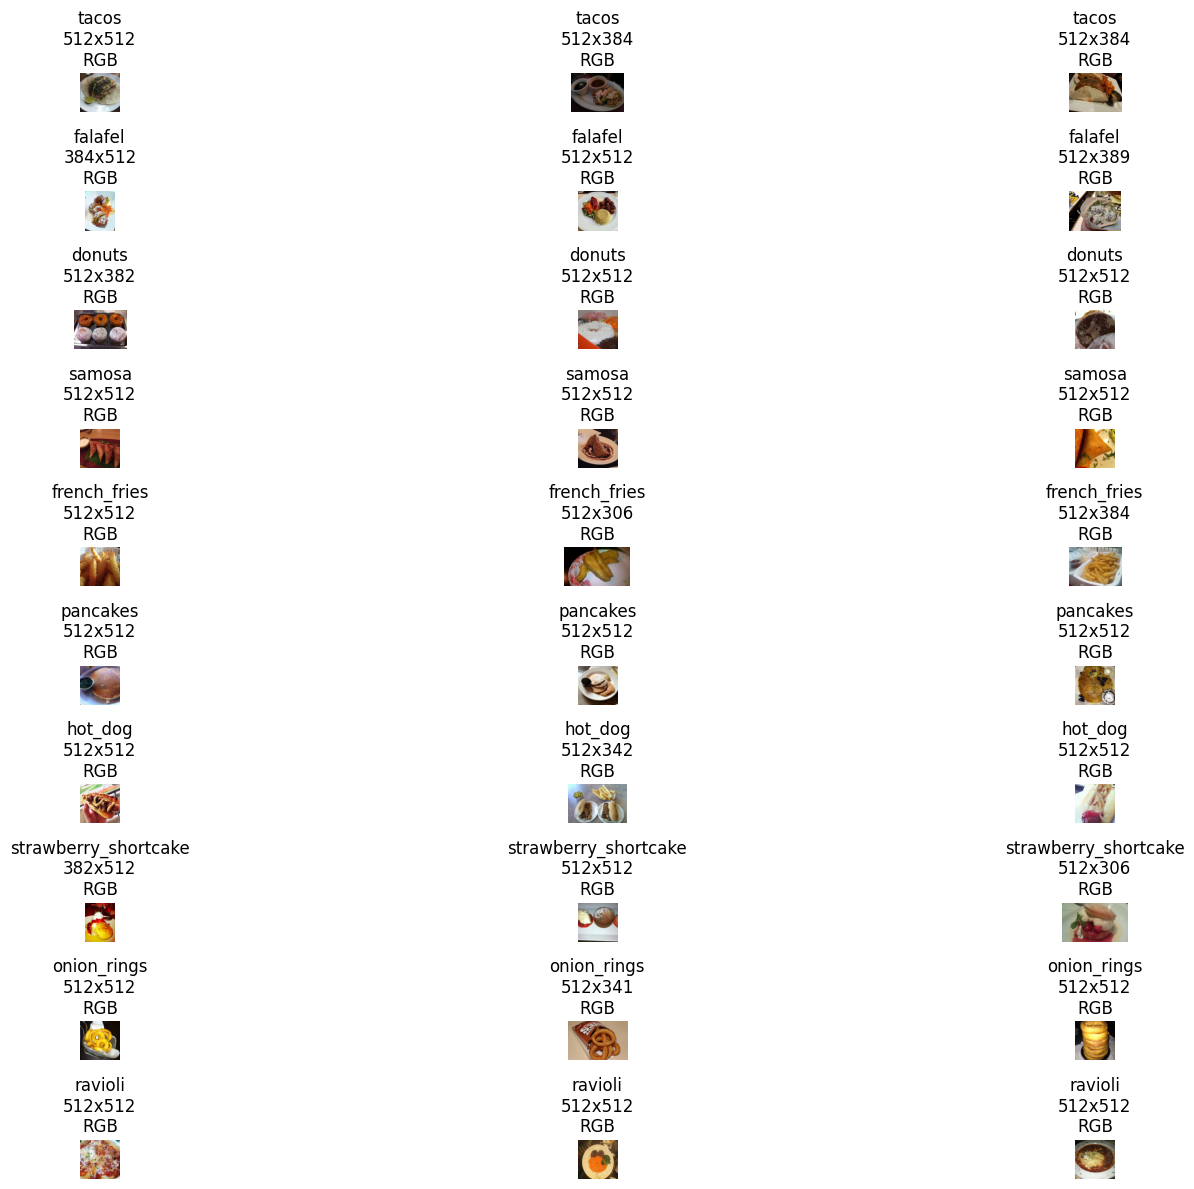

In [ ]:
# Updated configuration
n_classes_to_sample = 10
samples_per_class = 3
max_images = n_classes_to_sample * samples_per_class

plt.figure(figsize=(18, 12))
seen = {}
plotted = 0

for item in metadata:
    class_name = item.name
    if seen.get(class_name, 0) < samples_per_class:
        img = cv2.imread(item.image_path())
        if img is None:
            print(f"Warning: Could not read image {item.image_path()}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, channels = img.shape
        is_grayscale = channels == 1

        plt.subplot(n_classes_to_sample, samples_per_class, plotted + 1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{width}x{height}\n{'Gray' if is_grayscale else 'RGB'}")
        plt.axis('off')

        seen[class_name] = seen.get(class_name, 0) + 1
        plotted += 1

        if plotted >= max_images:
            break

plt.tight_layout()
plt.show()


### Observations:

- Consistent Color Space:
    - All images are RGB, which is standard and expected for deep learning models using convolutional networks.

- Variable Image Dimensions:
    - Although most images are square (512x512), several have non-square resolutions (e.g., 512x342, 382x512, 512x384).
    - This introduces aspect ratio variability, which may affect model performance if not handled properly.

- Centered Composition:
    - Most food items appear well-centered, with minimal background clutter.
    - This suggests that the bounding boxes or crops (if applied) were done with reasonable accuracy.

- Intra-class Variation:
    - Each class (e.g., samosa, falafel, apple_pie) shows visual variation in texture, orientation, and plating.
    - This is beneficial for training robust classifiers but may require data augmentation to generalize well.


- Preprocessing Needed:
    - Normalize image sizes (e.g., resize all to 224×224 or 299×299 depending on model input).
    - Consider aspect ratio preservation or intelligent cropping.

- Data Augmentation Recommended:

    - Techniques like random cropping, rotation, zoom, and brightness adjustments will improve generalization.

- Improves Model Generalization:

    - Bounding boxes help the model learn discriminative visual patterns with greater consistency across the dataset.

In [ ]:
# Create a DataFrame to show class distribution
class_counts = {}

for class_name in os.listdir(food_101_image_folder):
    if os.path.isdir(os.path.join(food_101_image_folder, class_name)):
        class_size = len(os.listdir(os.path.join(food_101_image_folder, class_name)))
        class_counts[class_name] = class_size

df = pd.DataFrame(list(class_counts.items()), columns=['class_name', 'class_size'])
df.set_index('class_name', inplace=True)
df


class_size
class_name                      
tacos                       1000
falafel                     1000
donuts                      1000
samosa                      1000
french_fries                1000
pancakes                    1000
hot_dog                     1000
strawberry_shortcake        1000
onion_rings                 1000
ravioli                     1000
nachos                      1000
apple_pie                    257
ice_cream                   1000
waffles                     1000
chocolate_cake              1000
pizza                       1000
spring_rolls                1000

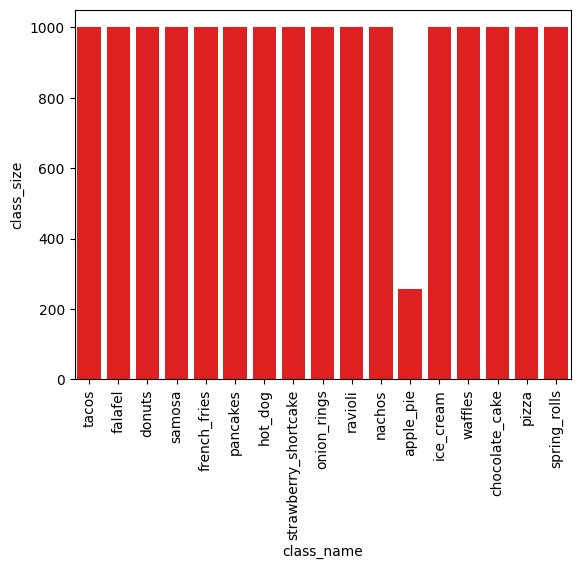

In [ ]:
# show in barplot
sns.barplot(x=df.index, y=df['class_size'],color='r')
plt.xticks(rotation=90)
plt.show()

#### Observation:

1. **Uniform Distribution Across Most Classes**  
   - Out of the 17 total food classes, **16 classes have exactly 1000 images**.  
   - This indicates a mostly well-balanced dataset, which is beneficial for training classification models without inherent bias.

2. **Class Imbalance – `apple_pie`**  
   - The `apple_pie` class has only **257 images**, which is significantly lower than the others.
   - This imbalance may negatively affect the model's ability to correctly classify `apple_pie`, leading to:
     - Lower recall and precision for the minority class.
     - Potential model bias toward majority classes.

3. **Potential Mitigation Strategies**  
   To address the class imbalance:
   - **Data Augmentation**: Apply augmentation (rotation, flipping, color jittering) to synthetically increase the number of `apple_pie` images.
   - **Class Weights**: Use class weights in the loss function during training to emphasize learning on the minority class.
   - **SMOTE or Oversampling Techniques** (if suitable for images).
   - **Undersampling** other classes (less preferred due to loss of valuable data).

4. **Impact on Model Evaluation**  
   - Use evaluation metrics such as **F1-score**, **Recall**, and **Confusion Matrix** in addition to Accuracy.
   - These metrics will better highlight the model’s performance on the imbalanced class.

5. **Need for Visual Exploration**  
   - Visual inspection of `apple_pie` images may help understand why the count is low (e.g., ambiguous visuals, data collection issue).




---



## Visual Inspection of Annotated Images (With Bounding Boxes)


The **Food101** dataset contains a total of **16,256 images** categorized into **17 different food classes**. Each class represents a type of food, such as `apple_pie`, `pizza`, `samosa`, etc.

This section presents a **visual inspection of sample images with bounding box annotations**, which highlight the region of interest (i.e., the food item) within each image.

### Key Details:
- The dataset can be split into **training and testing sets** in a **70-30 ratio** per class.
- Each food category has approximately **1,000 images**, except for `apple_pie`, which has fewer samples.
- Bounding boxes help localize the food item in the image, which is useful for object detection or improving classification accuracy by focusing the model on relevant image regions.

### Purpose of this Visualization:
- To visually verify the quality and accuracy of bounding box annotations.
- To understand how localized regions differ across classes and image samples.
- To evaluate whether bounding box information can aid in better feature learning for classification or detection tasks.

Below, we inspect a few representative examples from different classes with their bounding boxes overlaid.


---

### Dataset Annotation Overview

We have successfully annotated our image dataset and stored the results in a file named `annotation_csv`. This file adheres to the **YOLO format**, with the following columns:

- **`image_name`**: Name of the image file.
- **`class_name`**: Object category label.
- **`x_center`**, **`y_center`**, **`width`**, **`height`**: Bounding box coordinates **normalized to the [0, 1] range**.

---

### How We Annotated the Data

We used a hybrid approach combining **automated tools** and **AI assistance** to efficiently generate high-quality annotations:

-  **YOLOv8 and YOLOv11**: Employed for automatic object detection and initial bounding box generation.
  
-  **ChatGPT API**: Used to **pass images directly** and **receive bounding box predictions** for objects, especially helpful in cases requiring semantic understanding or where pretrained models struggled.

-  **Roboflow**: Used as a platform for annotation review, correction, and dataset management. It helped streamline the export process into YOLO format and ensured consistency.

---

###  Usage in Training Pipeline

The `annotation_csv` will be used for:

-  **Data Preparation**: Parsing annotations in YOLO format for image-label mapping.
- **Model Training**: Feeding normalized bounding boxes and class labels into the training pipeline.

This multi-tool approach ensures a robust, scalable, and AI-assisted annotation pipeline tailored for object detection tasks.




#### Loading Annotation Data and Extracting Food Classes

In this step, we load the refined annotation data from the `Food_101_Annotation` directory. The annotation file (`annotation_refined.csv`) contains important metadata such as image file names, bounding box coordinates, and corresponding food class labels.

We extract and display the list of **unique food classes** present in the dataset to understand the classification scope.


In [5]:
!unzip '/content/drive/MyDrive/Python Course_shared/computer Vision/annotation/Food-101-Annotated-V3.zip'


Archive:  /content/drive/MyDrive/Python Course_shared/computer Vision/annotation/Food-101-Annotated-V3.zip
   creating: Food-101-Annotated/
  inflating: __MACOSX/._Food-101-Annotated  
   creating: Food-101-Annotated/ice_cream/
  inflating: __MACOSX/Food-101-Annotated/._ice_cream  
   creating: Food-101-Annotated/samosa/
  inflating: __MACOSX/Food-101-Annotated/._samosa  
  inflating: Food-101-Annotated/.DS_Store  
  inflating: __MACOSX/Food-101-Annotated/._.DS_Store  
   creating: Food-101-Annotated/onion_ring/
  inflating: __MACOSX/Food-101-Annotated/._onion_ring  
   creating: Food-101-Annotated/strawberry_shortcake/
  inflating: __MACOSX/Food-101-Annotated/._strawberry_shortcake  
   creating: Food-101-Annotated/waffle/
  inflating: __MACOSX/Food-101-Annotated/._waffle  
  inflating: Food-101-Annotated/annotation_refined.csv  
  inflating: __MACOSX/Food-101-Annotated/._annotation_refined.csv  
   creating: Food-101-Annotated/chocolate_cake/
  inflating: __MACOSX/Food-101-Annotated/

In [ ]:
# Correct data directory path
data_dir = 'Food-101-Annotated/'

# Read the annotation file
annotations_df = pd.read_csv('Food-101-Annotated/annotation_refined.csv')

classes = annotations_df['class_name'].unique()

print("Available food classes:")
classes.tolist()

Available food classes:


['french_fries',
 'nachos',
 'chocolate_cake',
 'samosa',
 'ice_cream',
 'strawberry_shortcake',
 'pizza',
 'tacos',
 'waffle',
 'onion_ring']

In [ ]:
# Display first few rows of annotations dataframe
print("\nSample of Annotations Data:")
annotations_df.head()


Sample of Annotations Data:


image    class_name  x_center  y_center     width    height
0  1199754.jpg  french_fries  0.509375  0.522656  0.720313  0.771875
1  1232631.jpg        nachos  0.178125  0.717969  0.351562  0.439063
2  1232631.jpg        nachos  0.522656  0.511719  0.932813  0.954688
3  2616112.jpg        nachos  0.165625  0.526563  0.214844  0.465625
4  2616112.jpg        nachos  0.394531  0.482812  0.171875  0.379688

In [ ]:
# Display summary statistics of annotations
print("\nAnnotations DataFrame Info:")
annotations_df.info()



Annotations DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       1090 non-null   object 
 1   class_name  1090 non-null   object 
 2   x_center    1090 non-null   float64
 3   y_center    1090 non-null   float64
 4   width       1090 non-null   float64
 5   height      1090 non-null   float64
dtypes: float64(4), object(2)
memory usage: 51.2+ KB


In [ ]:
# Display value counts of classes
print("\nClass Distribution:")
annotations_df['class_name'].value_counts()


Class Distribution:


class_name
samosa                  193
onion_ring              176
nachos                  143
ice_cream               125
tacos                   117
french_fries             81
pizza                    68
strawberry_shortcake     67
waffle                   65
chocolate_cake           55
Name: count, dtype: int64

In [ ]:
# Display value counts of classes
print("\nClass Distribution:")
annotations_df.describe()


Class Distribution:


x_center     y_center        width       height
count  1090.000000  1090.000000  1090.000000  1090.000000
mean      0.503608     0.485872     0.533300     0.502740
std       0.174767     0.152479     0.257276     0.234620
min       0.067187     0.102344     0.001563     0.002344
25%       0.397656     0.392383     0.327539     0.314844
50%       0.503125     0.492188     0.487109     0.463672
75%       0.603125     0.572656     0.753906     0.683594
max       0.953125     0.920312     1.000000     1.000000

#### Visualizing Sample Images with Bounding Boxes for Each Food Class

This section displays a visual grid of sample images from the **Food-101** dataset, annotated with **bounding boxes** for each food class. The goal is to provide a clear, visual understanding of how food items are localized within images and to verify the accuracy of the annotations.

1. french_fries
2. nachos
3. chocolate_cake
4. samosa
5. ice_cream
6. strawberry_shortcake
7. pizza
8. tacos
9. waffle
10. onion_ring

Processing class: french_fries


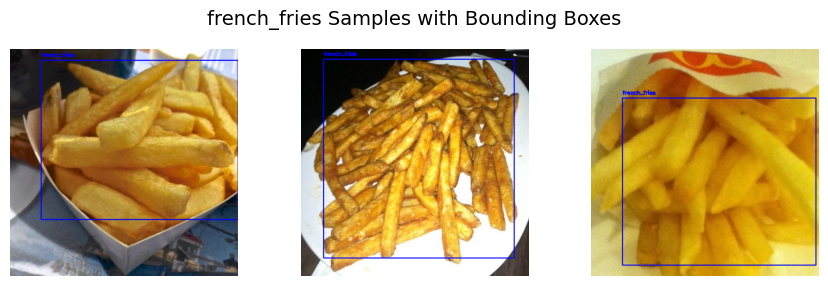


Processing class: nachos


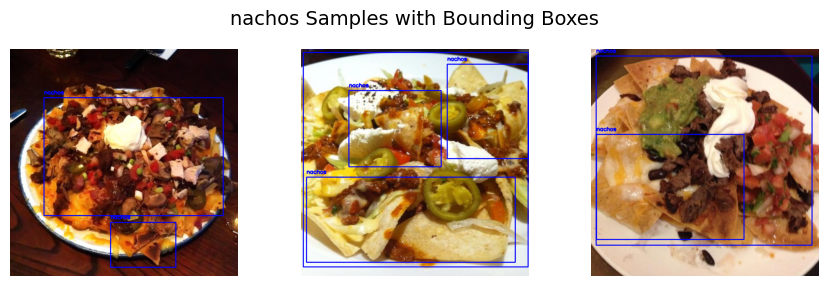


Processing class: chocolate_cake


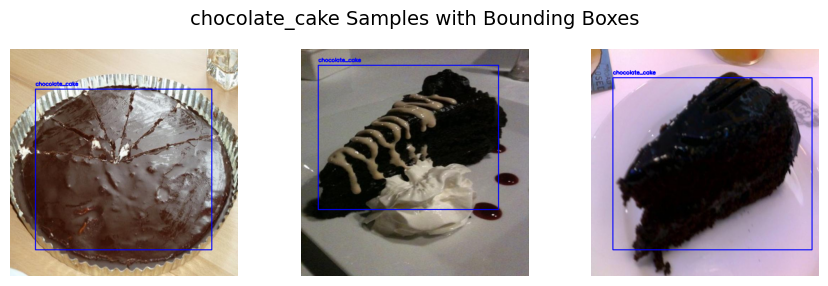


Processing class: samosa


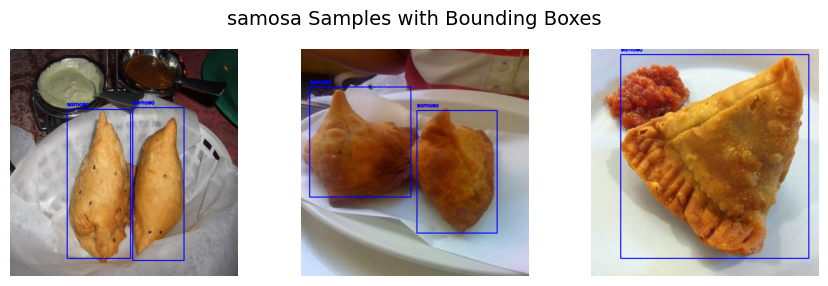


Processing class: ice_cream


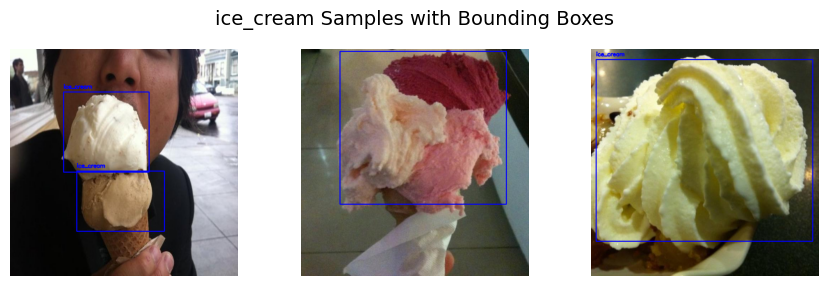


Processing class: strawberry_shortcake


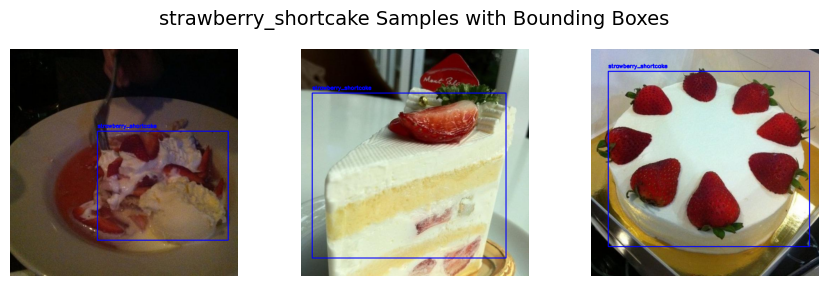


Processing class: pizza


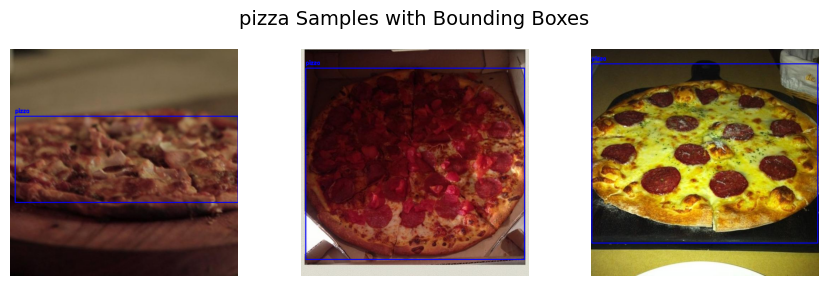


Processing class: tacos


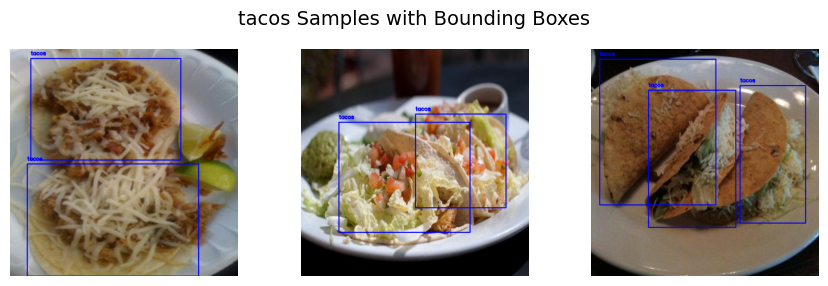


Processing class: waffle


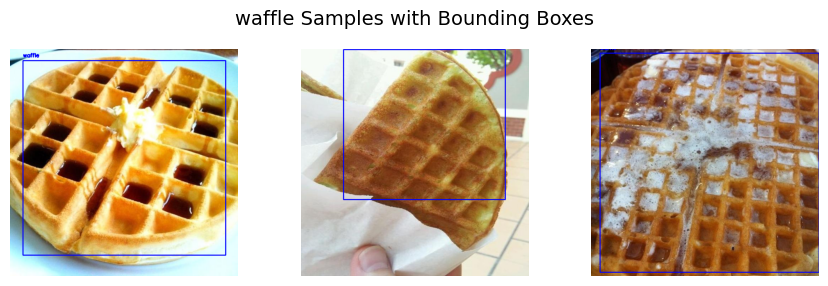


Processing class: onion_ring


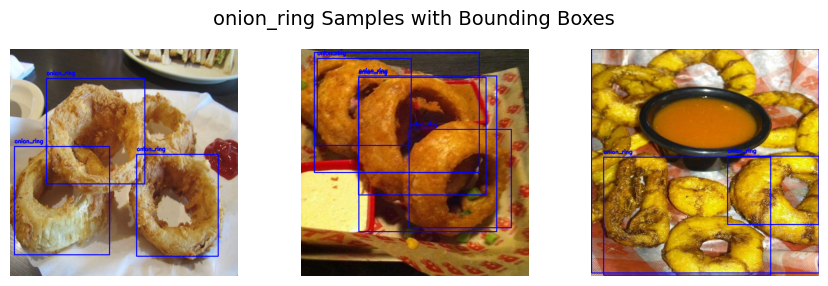

In [ ]:
import matplotlib.pyplot as plt
import random

for i, class_name in enumerate(classes, 1):
    print(f"{i}. {class_name}")

# Process each class separately with 3 images in a 1x3 grid
for food_class in classes:
    print(f"\nProcessing class: {food_class}")

    class_images = annotations_df[annotations_df['class_name'] == food_class]['image'].unique()
    selected_images = random.sample(list(class_images), min(3, len(class_images)))

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # Adjust width & height as needed
    axes = axes.ravel()

    for img_idx, image_file in enumerate(selected_images):
        draw_yolo_bboxes_from_csv(data_dir, image_file, annotations_df, axes[img_idx], food_class)

    # Title and spacing adjustments
    fig.suptitle(f"{food_class} Samples with Bounding Boxes", fontsize=14)
    plt.tight_layout(pad=2.0)  # Adjust pad to control spacing
    plt.subplots_adjust(top=0.85)  # Make space for suptitle
    plt.show()


# Model Building

 **Performance Metrics**: Metrics like accuracy, precision, recall, and F1-score should be evaluated. These metrics help assess the model's ability to distinguish between different food classes, especially when some are more challenging to classify.

# Preparing Data Set (Annotated) For Model
 We have annotated the datset and created a seperate annotation_csv file which contains imagename,classname and xcenter,ycenter,width,height (yolo format) all normalised 0to1.We will be using the same dataset for the model data preprartion and training


In [6]:
# base path of annotated images
base_path='Food-101-Annotated/'

In [7]:
# load image metadata from folder for training and testing
metadata_annotated = load_metadata(base_path)
annotation_df_model=pd.read_csv(f"{base_path}/annotation_refined.csv")

### Train Test Split With Image Generator

In [8]:
# Take first image only as there might have duplicate entryfor same image as same image mutiple instances of same food item
classification_df = annotation_df_model.groupby('image').first().reset_index()
# create a new volumn file name by concating the classname this will help us in using df for image data generator
classification_df['image_name'] = classification_df.apply(lambda row: f"{row['class_name']}/{row['image']}", axis=1)
# train test split with dividing the class in same propertion
train_df, temp_df = train_test_split(
    classification_df,
    test_size=0.2,
    stratify=classification_df['class_name'],  # ensures class distribution is preserved
    random_state=42)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['class_name'],  # ensures class distribution is preserved
    random_state=42)



In [9]:
print(f"Training Set ->{train_df.shape}",f"Validation Set ->{valid_df.shape}",f"Test Set ->{test_df.shape}")

Training Set ->(447, 7) Validation Set ->(56, 7) Test Set ->(56, 7)


In [10]:
df_1=classification_df.groupby('class_name').agg({'image':'count'}).reset_index()
df_2=train_df.groupby('class_name').agg({'image':'count'}).reset_index()
# Rename columns for clarity
df_1 = df_1.rename(columns={'image': 'total_count'})
df_2 = df_2.rename(columns={'image': 'train_count'})

# Merge on 'class_name'
result_df = pd.merge(df_1, df_2, on='class_name', how='outer')
result_df

class_name  total_count  train_count
0        chocolate_cake           51           41
1          french_fries           78           62
2             ice_cream           54           43
3                nachos           48           38
4            onion_ring           50           40
5                 pizza           58           46
6                samosa           71           57
7  strawberry_shortcake           50           40
8                 tacos           52           42
9                waffle           47           38

- We can see we have 447 for training 56 for testing and 56 will be for valiadation
- We can see each class is equally distributed 80% of total image set for the class from the aboce dataframe

In [11]:

# Define Image data generator for train and testvalidation
train_datagen =ImageDataGenerator(
                 horizontal_flip=True,
                 vertical_flip=True,
                 rotation_range=15,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 zoom_range=0.2,
                 shear_range=0.1,
                 fill_mode='nearest',
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
test_valid_datagen = ImageDataGenerator(rescale=1./255)


# Create training image gen
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=base_path,  # base path
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

# Create test image gen
test_gen = test_valid_datagen.flow_from_dataframe(
    test_df,
    directory=base_path,
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# Create valid image gen

valid_gen = test_valid_datagen.flow_from_dataframe(
    valid_df,
    directory=base_path,
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 446 validated image filenames belonging to 10 classes.
Found 56 validated image filenames belonging to 10 classes.
Found 56 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [12]:
print(train_gen.class_indices)
print(valid_gen.class_indices)
print(test_gen.class_indices)

{'chocolate_cake': 0, 'french_fries': 1, 'ice_cream': 2, 'nachos': 3, 'onion_ring': 4, 'pizza': 5, 'samosa': 6, 'strawberry_shortcake': 7, 'tacos': 8, 'waffle': 9}
{'chocolate_cake': 0, 'french_fries': 1, 'ice_cream': 2, 'nachos': 3, 'onion_ring': 4, 'pizza': 5, 'samosa': 6, 'strawberry_shortcake': 7, 'tacos': 8, 'waffle': 9}
{'chocolate_cake': 0, 'french_fries': 1, 'ice_cream': 2, 'nachos': 3, 'onion_ring': 4, 'pizza': 5, 'samosa': 6, 'strawberry_shortcake': 7, 'tacos': 8, 'waffle': 9}


In [ ]:
from collections import Counter

# Count how many instances per class
class_counts = Counter(test_gen.classes)

# Map class indices back to names
index_to_class = {v: k for k, v in test_gen.class_indices.items()}
class_distribution = {index_to_class[i]: count for i, count in class_counts.items()}

# Print result
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")

ice_cream: 6
french_fries: 8
chocolate_cake: 5
onion_ring: 5
strawberry_shortcake: 5
samosa: 7
tacos: 5
nachos: 5
pizza: 6
waffle: 4


### Observations:
We can see each classes have some images in test set

### Train Test Split Normal (without image generator)

In [ ]:
images = []
labels = []
for i in metadata_annotated:
  img = cv2.imread(i.image_path())
  if img is None:
    continue
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (128, 128))
  images.append(img_resized/255.0)
  labels.append(i.name)


In [ ]:
# Convert lists to arrays
X = np.array(images)
y = np.array(labels)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # one-hot encoding

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_valid.shape}, {y_valid.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (452, 128, 128, 3), (452, 10)
Valid: (56, 128, 128, 3), (56, 10)
Test: (57, 128, 128, 3), (57, 10)


# Model Creation

### Helper Function

In [13]:
def build_basic_cnn(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Convolutional Block (Optional, but good for slightly more complexity)
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the 3D output to 1D for the Dense layers
    model.add(Flatten())

    # Dense (Fully Connected) Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) # Dropout for regularization to prevent overfitting
    model.add(Dense(num_classes, activation='softmax')) # Output layer for classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
def build_basic_cnn_2(input_shape, num_classes, optimizer: Optimizer = Adam(learning_rate=0.001)):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile with the given optimizer
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:

def get_callbacks(filepath='cnn_model.weights.h5'):
    """
    Returns a tuple of callbacks: ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau.

    Parameters:
    -----------
    filepath : str
        Path to save the model weights.

    Returns:
    --------
    tuple :
        (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)
    """
    checkpointer = ModelCheckpoint(
        filepath=filepath,
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )

    earlystopping = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=20,
        mode='auto'
    )

    reduceLR = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        mode='auto'
    )

    return checkpointer, earlystopping, reduceLR


In [ ]:

def plot_model_accuracy(history,model):
    """
    Plots the accuracy and loss trends over epochs for a trained neural network.

    Parameters:
    - history: Keras History object containing training metrics.

    Displays:
    - Subplot 1: Training & Validation Accuracy vs. Epochs
    - Subplot 2: Training & Validation Loss vs. Epochs
    """

    h1 = history.history  # Extract training history

    # Get the final values for display in titles
    final_train_acc = h1['accuracy'][-1]
    final_val_acc = h1['val_accuracy'][-1]
    final_train_loss = h1['loss'][-1]
    final_val_loss = h1['val_loss'][-1]

    plt.figure(figsize=(15, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(y=h1['accuracy'], x=range(len(h1['accuracy'])), label="Training Accuracy", color="green")
    sns.lineplot(y=h1['val_accuracy'], x=range(len(h1['val_accuracy'])), label="Validation Accuracy", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(y=h1['loss'], x=range(len(h1['loss'])), label="Training Loss", color="orange")
    sns.lineplot(y=h1['val_loss'], x=range(len(h1['val_loss'])), label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")
    plt.legend()

    plt.show()


In [ ]:
def plot_confusion_matrix(model, test_generator, class_names=None, palette='Set2'):
    """
    Plots a confusion matrix heatmap for a model and a generator-based test dataset.

    Parameters:
    - model: Trained Keras model
    - test_generator: Generator for test data
    - class_names: List of class names (optional)
    - palette: Color palette for heatmap (default: 'Blues')

    Displays:
    - Heatmap of confusion matrix
    """
    # Get predictions and true labels
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes  # true labels from generator

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels)

    if class_names is None and hasattr(test_generator, 'class_indices'):
        class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=palette,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
def visualize_predictions(model, test_generator, class_names=None, num_images=12):
    """
    Visualize predictions made by a model on a test generator.

    Parameters:
    - model: Trained Keras model.
    - test_generator: ImageDataGenerator with shuffle=False.
    - class_names: List of class names (optional). If None, will use from generator.
    - num_images: Number of images to display.
    """
    # Get batch of images and labels
    images, labels = next(iter(test_generator))
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    # Use class names from generator if not provided
    if class_names is None:
        class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}",
                  color='green' if pred_labels[i] == true_labels[i] else 'red')
    plt.tight_layout()
    plt.show()



In [ ]:
def generate_classification_report(model, test_generator):
    """
    Generate and print a classification report using a Keras model and an image data generator.

    Parameters:
    - model: Trained Keras model
    - test_generator: ImageDataGenerator.flow_from_directory object, must be created with shuffle=False
    """
    # Get true labels
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Predict probabilities
    y_pred_probs = model.predict(test_generator, verbose=1)

    # Convert to predicted class indices
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))




---



## With Default Train Test Set (without Balanced)

In [ ]:
# Define checkpint eraly stopping call back
checkpointer, earlystopping, reduceLR=get_callbacks(filepath='model_2.weights.h5')

In [ ]:
# create model
K.clear_session()
cnn_model=build_basic_cnn((128, 128, 3), 10)

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = cnn_model.fit(
    X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpointer, reduceLR, earlystopping]

    )

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.1012 - loss: 2.4096
Epoch 1: val_loss did not improve from 1.63336
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.1026 - loss: 2.4065 - val_accuracy: 0.2143 - val_loss: 2.2699 - learning_rate: 0.0010
Epoch 2/50
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1540 - loss: 2.2638
Epoch 2: val_loss did not improve from 1.63336
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1594 - loss: 2.2615 - val_accuracy: 0.1786 - val_loss: 2.1883 - learning_rate: 0.0010
Epoch 3/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2272 - loss: 2.1487
Epoch 3: val_loss did not improve from 1.63336
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2259 - loss: 2.1507 - val_accuracy: 0.2143 - val_loss: 2.1650 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2670 - loss: 2.0638
Epoch 4: val_loss did not improve from 1.63336
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy

Model is overfitting

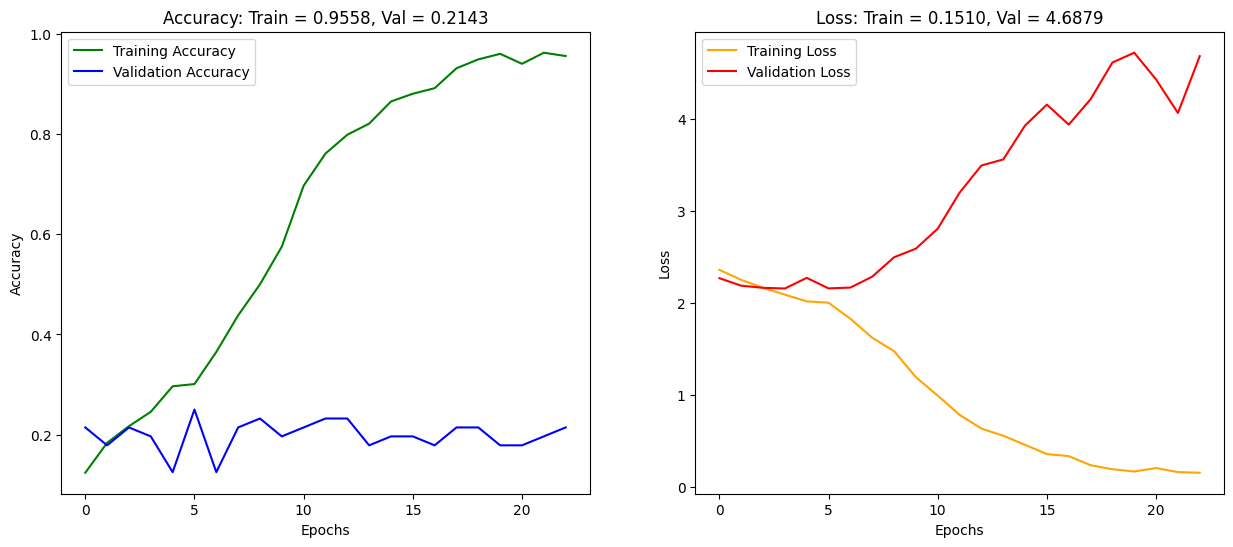

In [ ]:
plot_model_accuracy(history,cnn_model)

### Observation:
The training and validation curve is diverging .Not a good model for further analysis

## With Image Generator And balanced Train Set (Adam)

In [ ]:
# check point and eraly stopping call back
checkpointer, earlystopping, reduceLR=get_callbacks(filepath='model_2.weights.h5')

In [ ]:
# create basic model
K.clear_session()
model_2=build_basic_cnn((128, 128, 3), 10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compile model
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Starting training
history = model_2.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[checkpointer, reduceLR, earlystopping]
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.0865 - loss: 2.3364
Epoch 1: val_loss improved from inf to 2.29801, saving model to model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 631ms/step - accuracy: 0.0870 - loss: 2.3356 - val_accuracy: 0.1607 - val_loss: 2.2980 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1392 - loss: 2.2951
Epoch 2: val_loss improved from 2.29801 to 2.27082, saving model to model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.1395 - loss: 2.2951 - val_accuracy: 0.1964 - val_loss: 2.2708 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.1855 - loss: 2.2526
Epoch 3: val_loss improved from 2.27082 to 2.19070, saving model to model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.1848 - loss: 2.2515 - val_accuracy: 0.1786 - val_loss: 2.1907 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accurac

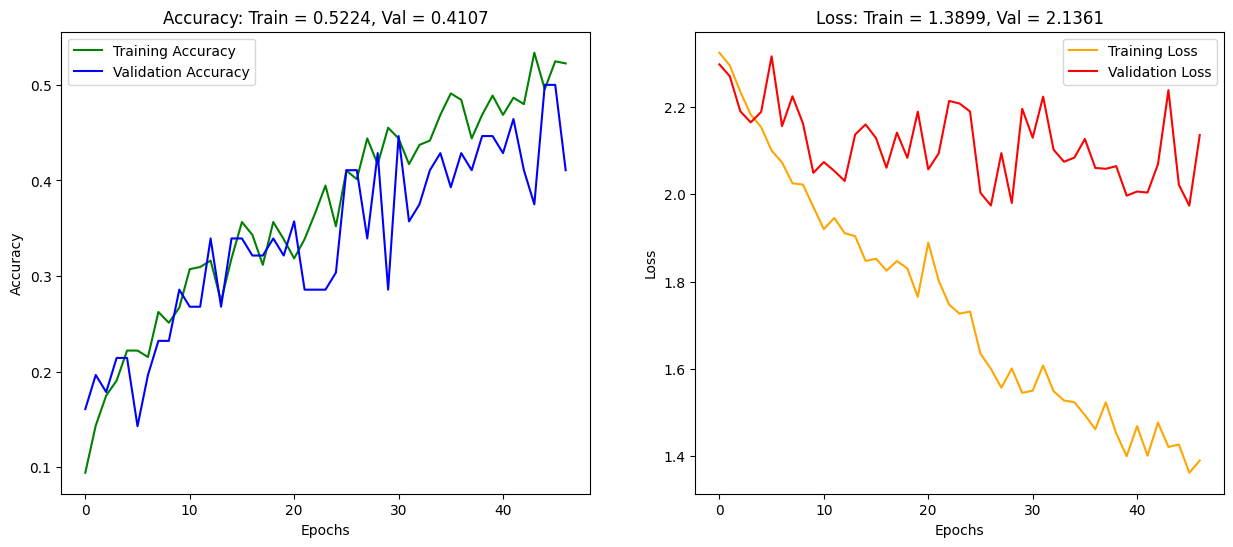

In [ ]:
plot_model_accuracy(history,model_2)

- So much noise in training and validation
- We can see its going up an down significantly and model training accuracy of 52% tells that model is failing to learn nuancest features

In [ ]:
model_2.evaluate(test_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5000 - loss: 1.5691


[1.6031839847564697, 0.5]

### Observations:
- Model failed to generalise as training accuracy is around 52% with validation accuracy is at 41%.
- Test acccuracy is around 50%
- We can see both validation and train curve has noises .

In [ ]:
# SHow classfication report
generate_classification_report(model_2, test_gen)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
                      precision    recall  f1-score   support

      chocolate_cake       1.00      1.00      1.00         5
        french_fries       0.50      0.62      0.56         8
           ice_cream       0.57      0.67      0.62         6
              nachos       0.33      0.20      0.25         5
          onion_ring       0.20      0.20      0.20         5
               pizza       0.55      1.00      0.71         6
              samosa       0.17      0.14      0.15         7
strawberry_shortcake       1.00      0.40      0.57         5
               tacos       0.50      0.40      0.44         5
              waffle       0.33      0.25      0.29         4

            accuracy                           0.50        56
           macro avg       0.52      0.49      0.48        56
        weighted avg       0.51      0.50      0.48        56



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


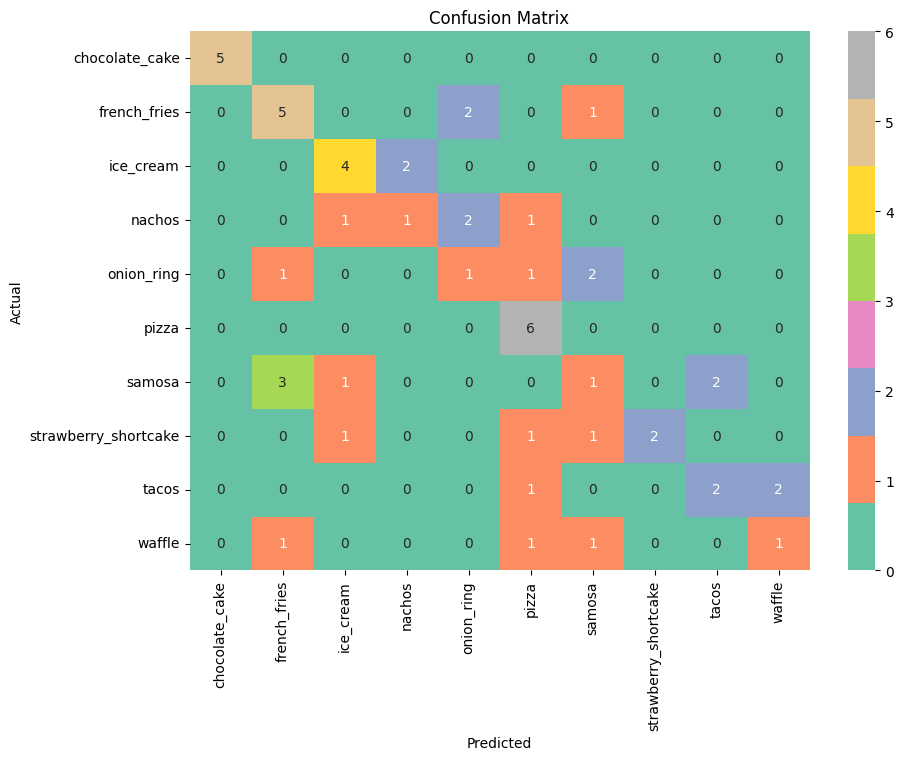

In [ ]:
# Show Confusion matrix
plot_confusion_matrix(model_2,test_gen,list(test_gen.class_indices.keys()))

### Observations:
- **Overall Test Accuracy**: 50%
- **Overall Accuracy** is at 52%

- **High Performing Classes**: `chocolate_cake`, `pizza`, `ice_cream` show good precision and recall.
- **Poorly Learned Classes**: `samosa`, `onion_ring`, `strawberry_shortcake` — either completely misclassified or low recall.


## Model With He normal and more layers(Adam)

In [ ]:
# check point and eraly stopping call back
checkpointer, earlystopping, reduceLR=get_callbacks(filepath='cnn_model_2.weights.h5')

In [ ]:
# define the model bulding from utility
K.clear_session()
cnn_model_2=build_basic_cnn_2((128, 128, 3), 10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = cnn_model_2.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[checkpointer, reduceLR, earlystopping]
    )

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.0770 - loss: 2.7664
Epoch 1: val_loss improved from inf to 2.28435, saving model to cnn_model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 409ms/step - accuracy: 0.0777 - loss: 2.7506 - val_accuracy: 0.1250 - val_loss: 2.2843 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1141 - loss: 2.2798
Epoch 2: val_loss improved from 2.28435 to 2.22756, saving model to cnn_model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.1152 - loss: 2.2794 - val_accuracy: 0.1429 - val_loss: 2.2276 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.1768 - loss: 2.1937
Epoch 3: val_loss did not improve from 2.22756
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.1764 - loss: 2.1945 - val_accuracy: 0.1250 - val_loss: 2.2510 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1337 - loss: 2.2320
Epoch 4:

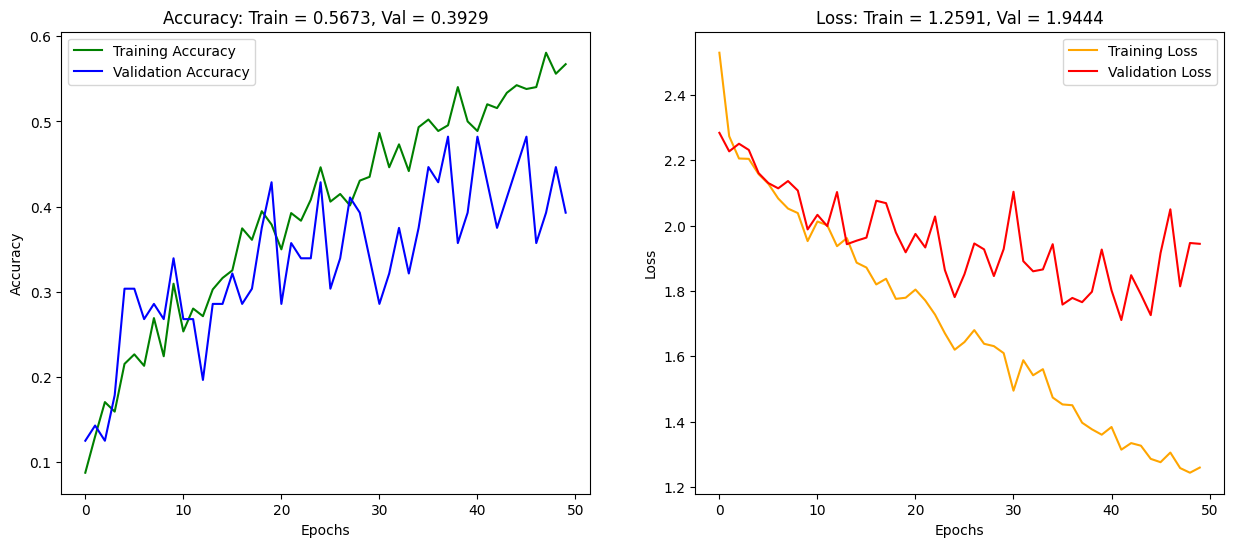

In [ ]:
plot_model_accuracy(history,cnn_model_2)

In [ ]:
cnn_model_2.evaluate(test_gen)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4643 - loss: 1.6471


[1.7094813585281372, 0.4464285671710968]

In [ ]:
# SHow classfication report
generate_classification_report(cnn_model_2, test_gen)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
                      precision    recall  f1-score   support

      chocolate_cake       0.80      0.80      0.80         5
        french_fries       0.40      0.50      0.44         8
           ice_cream       0.43      0.50      0.46         6
              nachos       0.00      0.00      0.00         5
          onion_ring       0.25      0.20      0.22         5
               pizza       0.55      1.00      0.71         6
              samosa       0.40      0.29      0.33         7
strawberry_shortcake       1.00      0.60      0.75         5
               tacos       0.40      0.40      0.40         5
              waffle       0.00      0.00      0.00         4

            accuracy                           0.45        56
           macro avg       0.42      0.43      0.41        56
        weighted avg       0.43      0.45      0.42        56



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


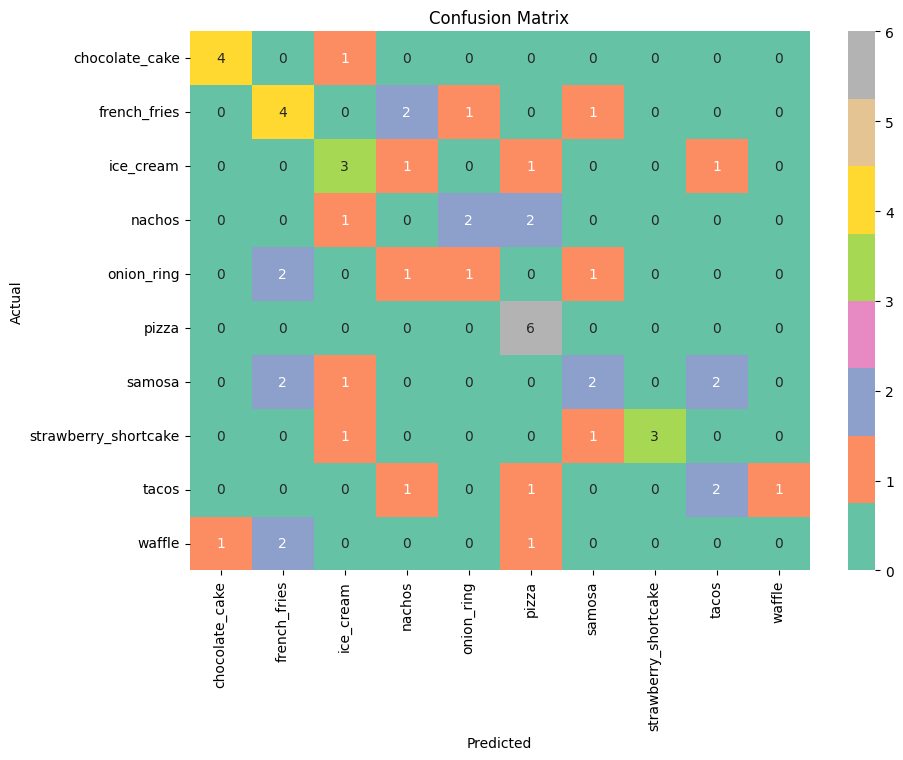

In [ ]:
plot_confusion_matrix(cnn_model_2,test_gen,list(test_gen.class_indices.keys()))

### Observation

- **Test accuracy** is at 45%
- **Overall Accuracy**: 43% — lesser from previous model which is at 50% .
- **Well-Classified Classes**:
  - `chocolate_cake`, `pizza`, `ice_cream`: Good precision and recall.
- **Moderate Performance**:
  - `french_fries`, `tacos`, `onion_ring`: Acceptable but need improvement.
- **Poorly Classified Classes**:
  - `samosa`, `nachos`, `waffle`, `strawberry_shortcake`: Low recall or F1-score; waffle has 0% recall.

### With he_normal and SGD

In [ ]:
checkpointer, earlystopping, reduceLR=get_callbacks(filepath='cnn_model_sgd.weights.h5')

In [ ]:
K.clear_session()
cnn_model_sgd=build_basic_cnn_2((128, 128, 3), 10,SGD(learning_rate=0.001))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model_sgd.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = cnn_model_sgd.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[checkpointer, reduceLR, earlystopping]
    )

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.1100 - loss: 2.9104
Epoch 1: val_loss improved from inf to 2.28927, saving model to cnn_model_sgd.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.1116 - loss: 2.8890 - val_accuracy: 0.1071 - val_loss: 2.2893 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1326 - loss: 2.3050
Epoch 2: val_loss improved from 2.28927 to 2.27802, saving model to cnn_model_sgd.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.1324 - loss: 2.3047 - val_accuracy: 0.1429 - val_loss: 2.2780 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1410 - loss: 2.2769
Epoch 3: val_loss improved from 2.27802 to 2.25607, saving model to cnn_model_sgd.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.1400 - loss: 2.2771 - val_accuracy: 0.2143 - val_loss: 2.2561 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18

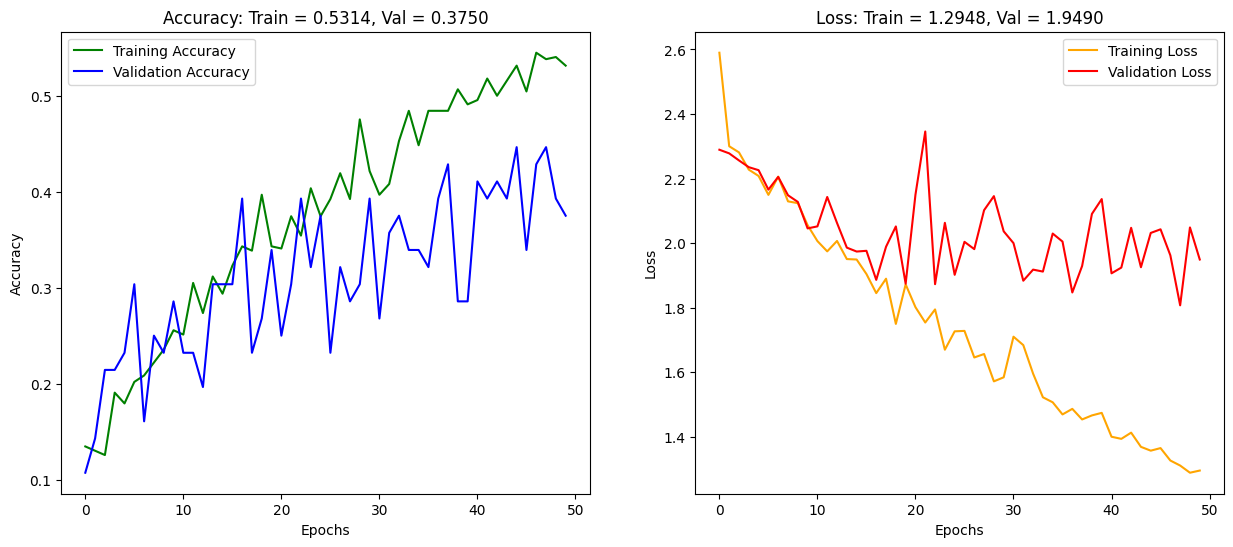

In [ ]:
plot_model_accuracy(history,cnn_model_sgd)

In [ ]:
cnn_model_sgd.evaluate(test_gen)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5000 - loss: 1.6595


[1.6906964778900146, 0.5]

### Observations:
Not much Improvemnet with previous models .SGD did not make the curve smooth.Though test score is same as first model  but the training and validation score are lesser then first model .

In [ ]:
# SHow classfication report
generate_classification_report(cnn_model_sgd, test_gen)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
                      precision    recall  f1-score   support

      chocolate_cake       0.83      1.00      0.91         5
        french_fries       0.50      0.75      0.60         8
           ice_cream       0.60      0.50      0.55         6
              nachos       0.00      0.00      0.00         5
          onion_ring       0.50      0.40      0.44         5
               pizza       0.50      1.00      0.67         6
              samosa       0.25      0.14      0.18         7
strawberry_shortcake       1.00      0.60      0.75         5
               tacos       0.40      0.40      0.40         5
              waffle       0.00      0.00      0.00         4

            accuracy                           0.50        56
           macro avg       0.46      0.48      0.45        56
        weighted avg       0.46      0.50      0.46        56



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


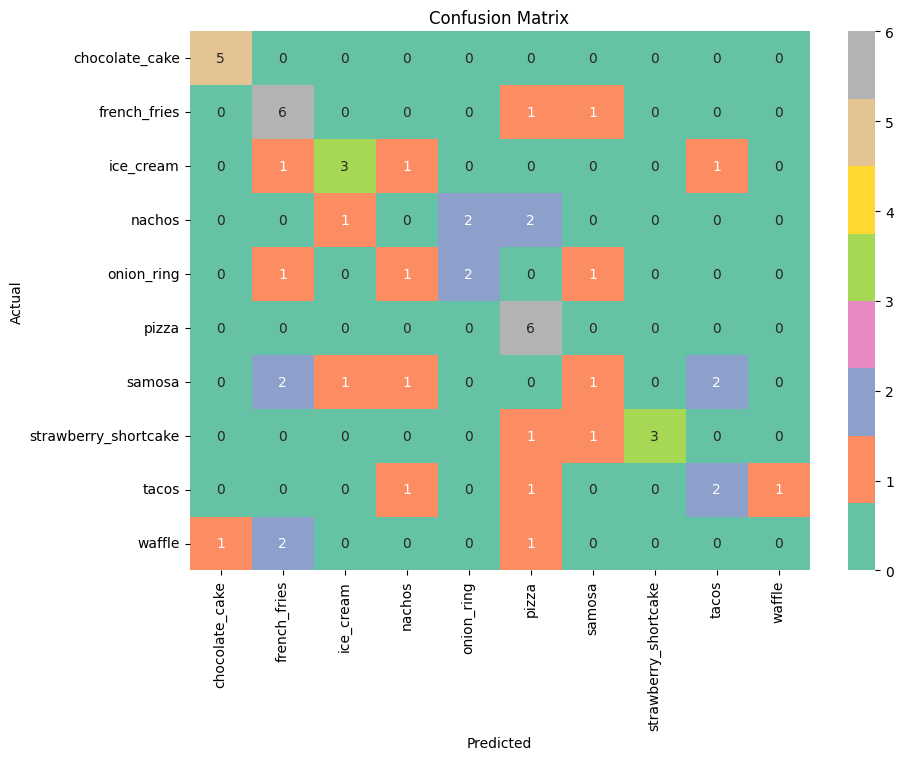

In [ ]:
# Show confusion matrix
plot_confusion_matrix(cnn_model_sgd,test_gen,list(test_gen.class_indices.keys()))

## Observations:
- **Test Accuracy**: 50%
- **Overall  Accuracy**: 46% less then 1st model (without he_normal)
- **High Performing Classes**: `chocolate_cake`, `pizza`, `ice_cream` show good precision and recall.
- **Poorly Learned Classes**: `samosa`, `onion_ring`, `strawberry_shortcake` — either completely misclassified or low recall.

Model performances is almost similar to 1st cnn model without he_normal and sgd(used Adam)

## Performances(Trained with Balnaced train,test,validation set):

###  Class-wise Observations

| Class                  | Best Model (based on F1)      | Comments                                  |
|------------------------|-------------------------------|-------------------------------------------|
| `chocolate_cake`       | Model 3(SGD+he_normal) (0.91)                | Excellent in all models.                  |
| `french_fries`         | Model 3(SGD+he_normal)) (0.60)                | Improved with SGD + He Normal.            |
| `ice_cream`            | Model 1(Adam) (0.62)                | Slight drop in Model 3.                   |
| `nachos`               | Model 1(Adam) (0.25)                | Still poor in all.                        |
| `onion_ring`           | Model 3(SGD+he_normal) (0.44)                | He Normal helped.                         |
| `pizza`                | Tie (1.00 recall in all)      | Always predicted correctly.               |
| `samosa`               | Model 2(Adam+henormal) (0.33)                | Still weak prediction.                    |
| `strawberry_shortcake`| Model 1 (0.57) / Model 2 & 3 (0.75) | Higher precision and recall with He Normal. |
| `tacos`               | Tie (~0.40 F1 across)         | Consistent poor performance.              |
| `waffle`               | Model 1(Adam) (0.29)                | Missed completely in Model 2 & 3.         |


### Visualizing the prediction (Model-1 Default Initializer and Adam):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


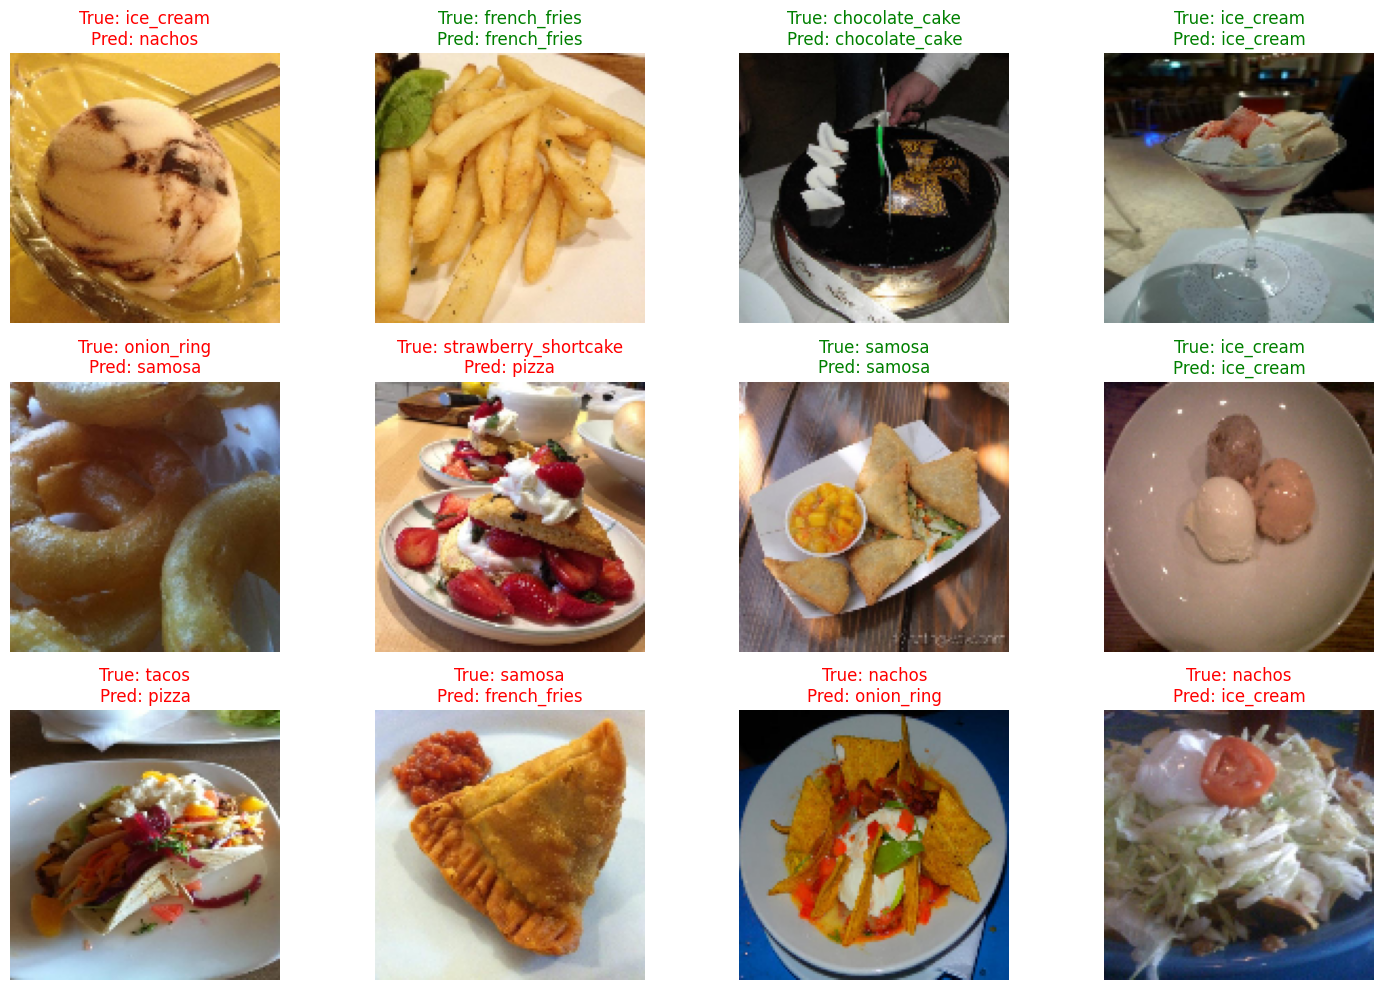

In [ ]:
# Visualise some predictions
visualize_predictions(model_2,test_gen,list(test_gen.class_indices.keys()))

### Observations:

- Strongest classes: chocolate_cake, pizza, ice_cream,French Fries

- Performs better on visually distinct items.

**Weaknesses:**

- Fails on subtle or similar-looking items: samosa, waffle, nachos, and strawberry_shortcake.
-  Somecases if there is some mayo like item in image it predict it as ice_cream might be due to similarity with icecream and mayo look.

- **Next Steps:**

- we can try adding more training data for weak classes.

- Use of  data augmentation or fine-tuning with class weighting to improve class balance.
- Use transfer leeraning from model like Efficientnet,mobilenet



### MileStone-2

## Optimization Of Previously Built CNN

In [16]:
train_datagen_augomented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,             # Increased rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,                # More zoom
    brightness_range=[0.8, 1.2],   # Random brightness
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'         # Keep fill mode as is
)


test_valid_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for validation


# Create training image gen
train_gen_2 = train_datagen_augomented.flow_from_dataframe(
    train_df,
    directory=base_path,  # base path
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

# Create test image gen
test_gen_2 = test_valid_datagen.flow_from_dataframe(
    test_df,
    directory=base_path,
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# Create valid image gen

valid_gen_2 = test_valid_datagen.flow_from_dataframe(
    valid_df,
    directory=base_path,
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 446 validated image filenames belonging to 10 classes.
Found 56 validated image filenames belonging to 10 classes.
Found 56 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [17]:
# use previously defined model with augomented image on image genarator
cnn_opt=build_basic_cnn((128, 128, 3), 10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnn_opt.fit(train_gen_2, epochs=50, validation_data=valid_gen_2)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.2415 - loss: 2.0514 - val_accuracy: 0.2857 - val_loss: 2.0827
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.2508 - loss: 2.0415 - val_accuracy: 0.2679 - val_loss: 2.0470
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.2875 - loss: 1.9549 - val_accuracy: 0.3393 - val_loss: 2.0942
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.2839 - loss: 1.9625 - val_accuracy: 0.2679 - val_loss: 2.1167
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.2668 - loss: 1.9914 - val_accuracy: 0.3214 - val_loss: 2.0588
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.2950 - loss: 1.9507 - val_accuracy: 0.3036 - val_loss: 2.0699
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.3135 - loss: 1.9089 - val_accuracy: 0.3036 - val_loss: 2.1616
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.2937 - loss: 1.9841 - val_accuracy: 0.

### Observation:
We donot see much improvement wirth training and validation

In [20]:
cnn_opt.evaluate(test_gen_2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4554 - loss: 1.5011


[1.5250766277313232, 0.4642857015132904]

### Observation:
No improvemnet with more augomenation like shear and zoom .its almost similar to previous performance .

## Use Transfer Learning